In [ ]:
#default_exp graphutils

# Utilities for manipulating and visualizing Dask graphs

In [ ]:
#export
import inspect
def graph_entry_to_string(graph_entry):
    func = graph_entry[0]
    argument_keys = list(inspect.signature(func).parameters.keys())
    return func.__module__.split('.')[-1] + "." + func.__name__ + "(" +\
           ", ".join(argument_keys[arg_idx] +"="+ arg.__repr__() for arg_idx, arg in enumerate(graph_entry[1:])) + ")"

def describe_graph(dask_graph):
    graph_description = {key: graph_entry_to_string(dask_graph[key])
                         for key in dask_graph.keys()}
    return graph_description


In [ ]:
from surfbreak import detection, graphutils
import pipelines
import graphchain

flow_fit_graph = pipelines.vid_to_fit_mean_flow_graph('./tmp/shirahama_1590387334_SURF-93cm.ts', n_samples=10)
describe_graph(flow_fit_graph)

Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]


{'flow_tensor_0': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=0, duration_s=1)",
 'flow_tensor_1': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=120, duration_s=1)",
 'flow_tensor_2': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=240, duration_s=1)",
 'flow_tensor_3': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=360, duration_s=1)",
 'flow_tensor_4': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=480, duration_s=1)",
 'flow_tensor_5': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=600, duration_s=1)",
 'flow_tensor_6': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=720, duration_s=1)",
 'flow_tensor_7': "detection.avg_wave_flows(video_file='./tmp/shirahama_1590387334_SURF-93cm.ts', start_s=840, du

In [ ]:
#export
import graphviz
import pprint
import dask
from dask.dot import graphviz_to_file
import numpy as np
import pandas as pd
import inspect


def short_func_label(func):
    return func.__name__

def full_func_label(func, daskgraph_entry):
    args_repr = []
    for arg in daskgraph_entry[1:]:
        if isinstance(arg, np.ndarray):
            args_repr.append("ndarray " + arg.shape.__repr__())
        elif isinstance(arg, pd.core.frame.DataFrame):
            args_repr.append("DataFrame")
        elif isinstance(arg, pd.core.series.Series):
            args_repr.append("Series")
        else:
            args_repr.append(arg)
     
    # Ugly....  build up a string that replicates a normal python function call signature, 
    # dealing with all of graphviz's wonkyness (like \l for left-justified newlines...)
    func_signature_segments = str(inspect.signature(func)).__repr__()[1:-1].split(', ')
    func_signature_string = ""
    cumulative_funcsig_len = len(func.__name__) + 1
    for segment in func_signature_segments:
        cumulative_funcsig_len += len(segment)
        if cumulative_funcsig_len > 50:
            cumulative_funcsig_len = 0
            if segment[-1] == ")":
                func_signature_string += segment + "   "
            else:
                func_signature_string += segment + ",\l" + 8*" "
        else:
            func_signature_string += segment + ",  " 

    func_string_with_signature = func.__name__  + func_signature_string[:-3]
    args_string = pprint.pformat(tuple(args_repr), indent=4)
    # In raw graphviz labels, '\l' indicates a newline with the previous-line left-justified (\n is centered)
    return func_string_with_signature + "\l" + args_string
    

def func_node_name(func, key):
    return short_func_label(func) + "_" + key
    

def to_digraph(daskgraph, data_attr={}, func_attr={}, graph_attr={"rankdir":"LR"}, short_labels=False):
    g = graphviz.Digraph(graph_attr=graph_attr)
    
    deps_dict = {k: dask.core.get_dependencies(daskgraph, k) for k in daskgraph}

    for k_name in deps_dict.keys():
        # Set up dask output nodes
        Dattrs = data_attr.get(k_name, {})
        Dattrs.setdefault("label", k_name)
        Dattrs.setdefault("shape", "box")
        g.node(k_name, **Dattrs)
        
        # Set up function nodes
        func = daskgraph[k_name][0]
        func_name = func_node_name(func, k_name)
        if short_labels:
            func_label = short_func_label(func)
        else:
            func_label = full_func_label(func, daskgraph[k_name])
        
        Fattrs = func_attr.get(k_name, {})
        Fattrs.setdefault("label", func_label)
        Fattrs.setdefault("shape", "ellipse")
        g.node(func_name, **Fattrs)
        
        g.edge(func_name, k_name)
        

    for k_name, deps in deps_dict.items():
        func = daskgraph[k_name][0]
        for dep in deps:
            dep_name = str(dep)
            g.edge(dep_name, func_node_name(func, k_name))
    return g

def digraph_to_png(digraph):
    return graphviz_to_file(digraph, None, 'png')

def visualize(daskgraph, short_labels=False, rankdir=None):
    if short_labels is True and rankdir is None:
        rankdir="UD"
    elif rankdir is None:
        rankdir="LR"        
    return digraph_to_png(to_digraph(daskgraph, short_labels=short_labels,
                                    graph_attr={"rankdir":rankdir}))

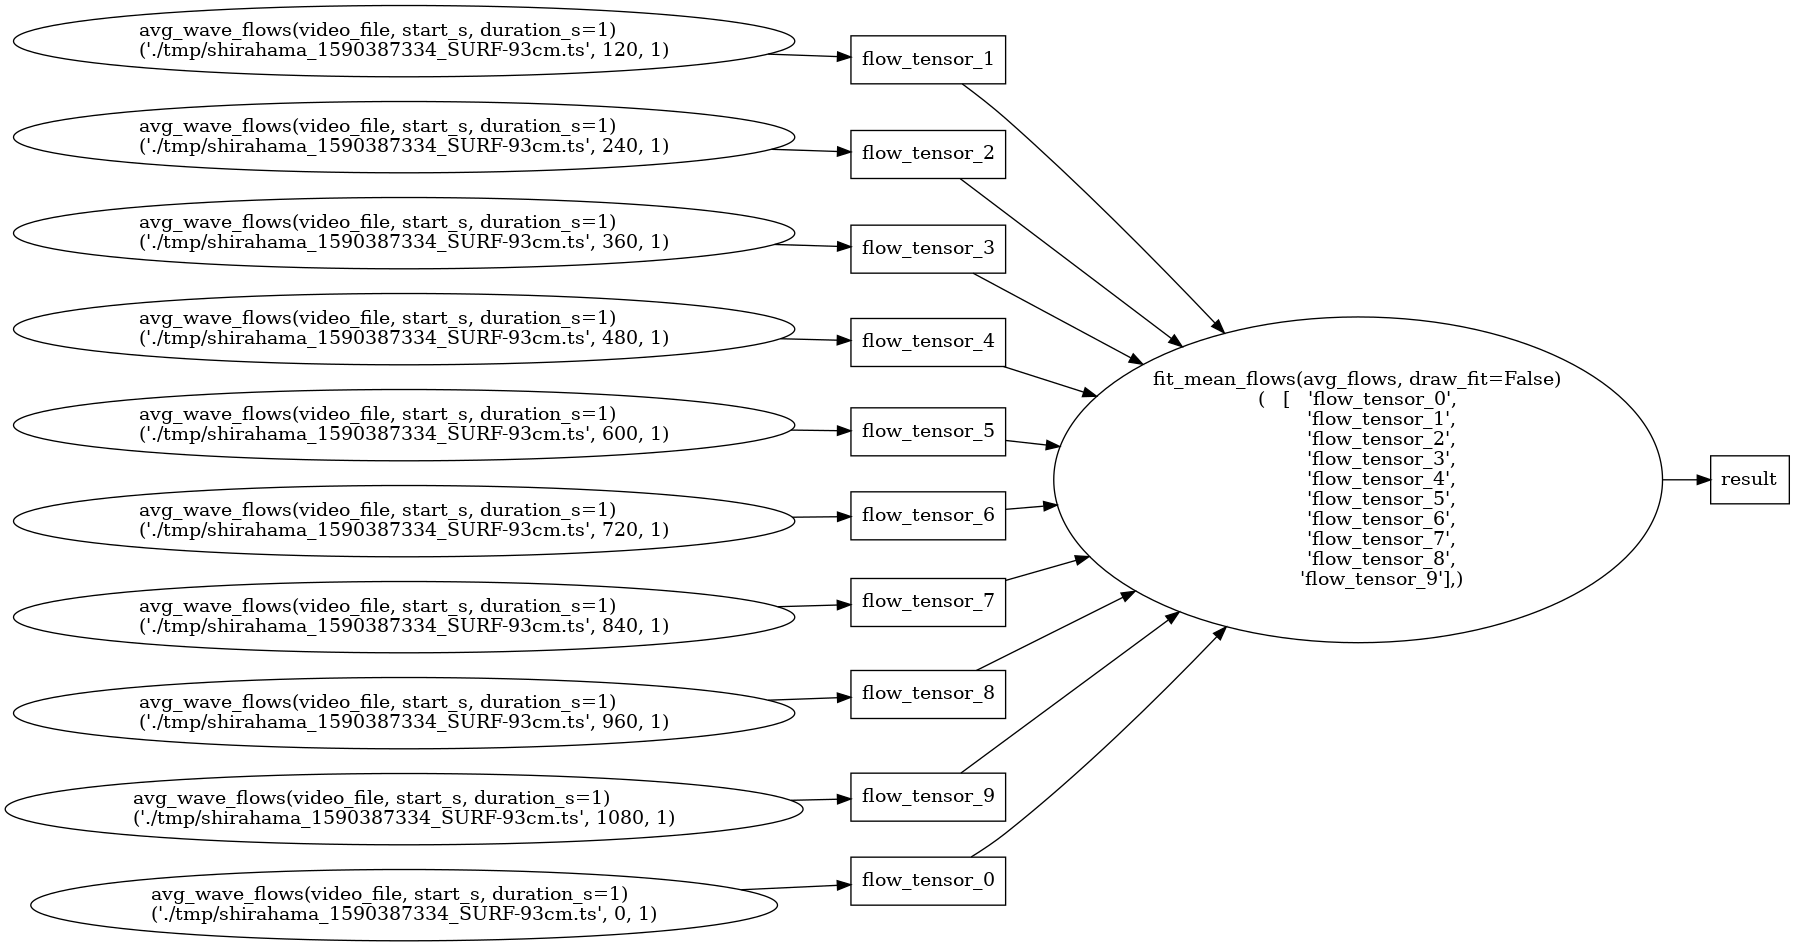

In [ ]:
visualize(flow_fit_graph)

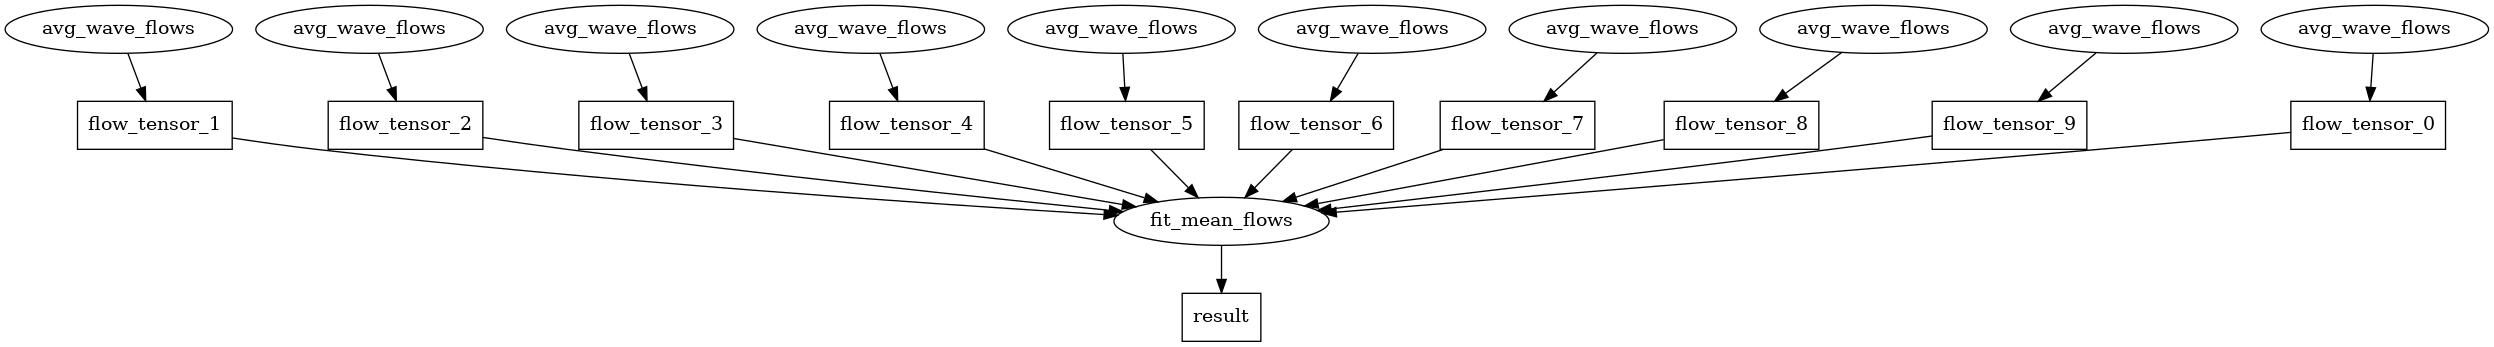

In [ ]:
visualize(flow_fit_graph, short_labels=True)

### Test out how the graph handles numpy and pandas objects

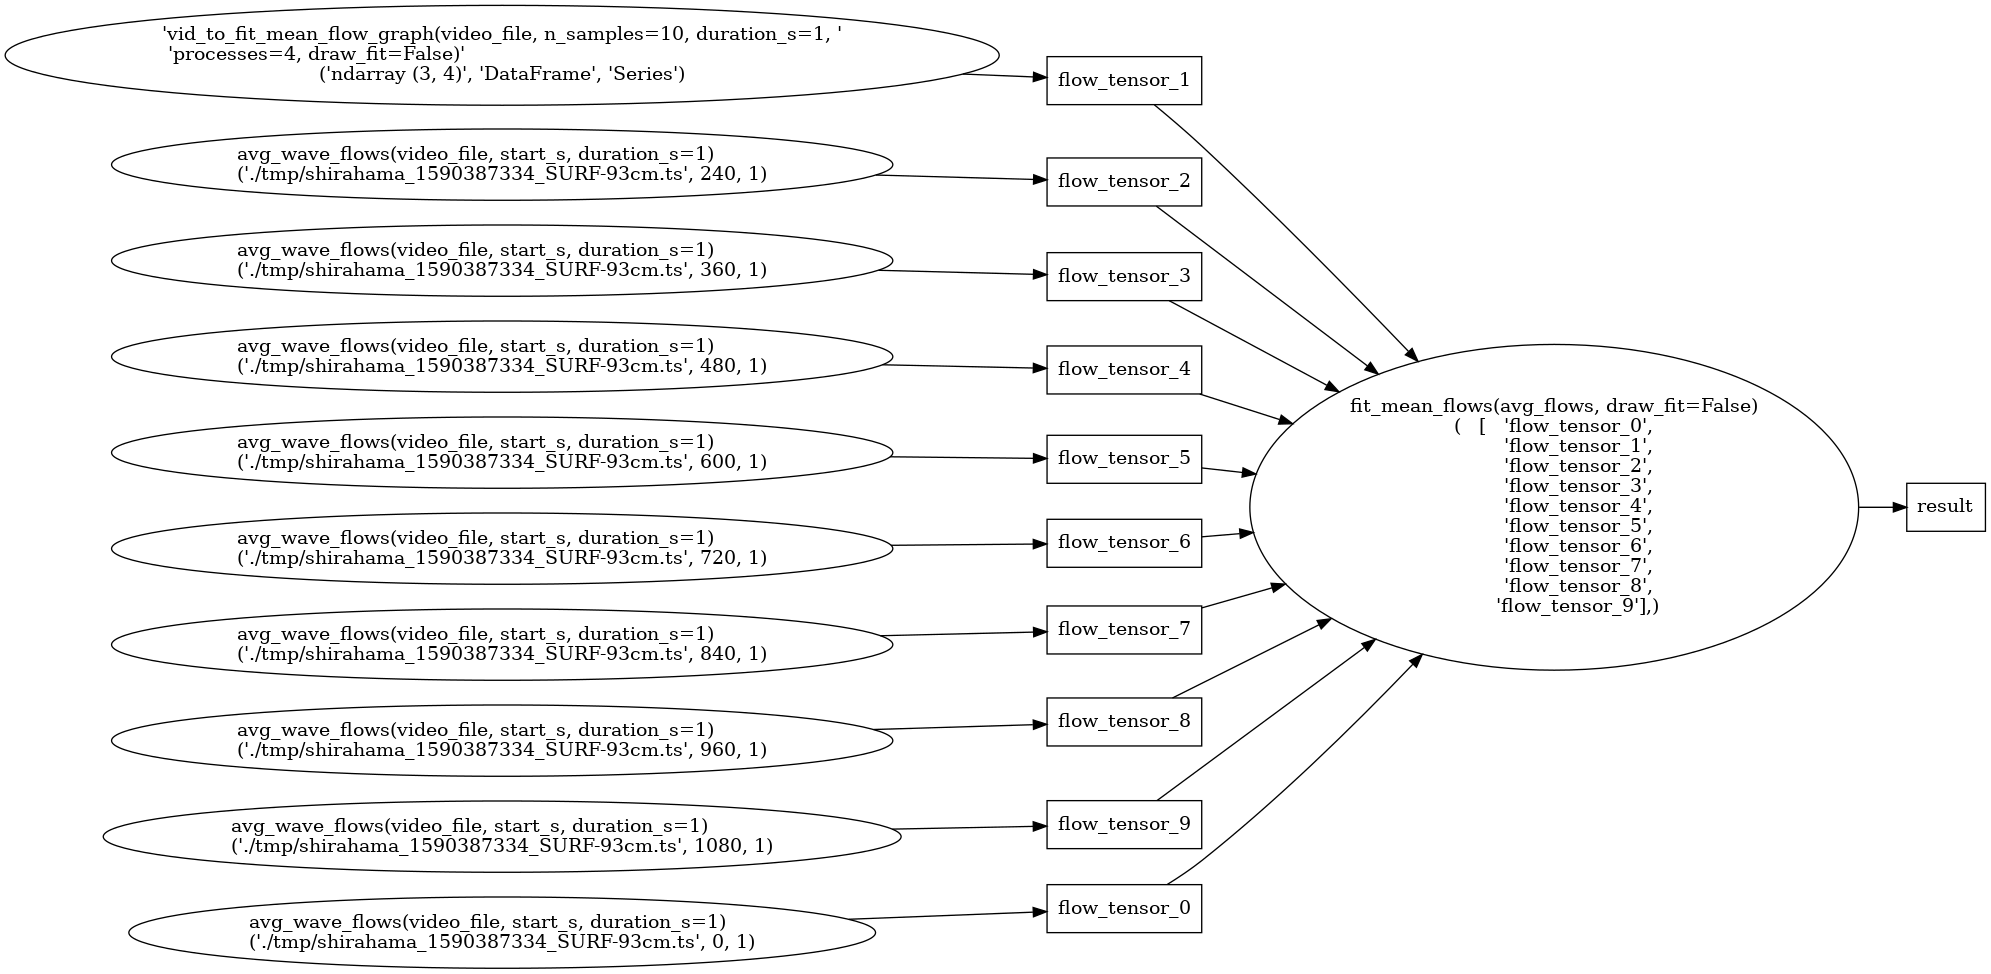

In [ ]:
import copy
test_graph = copy.deepcopy(flow_fit_graph)
test_graph['flow_tensor_1'] = (pipelines.vid_to_fit_mean_flow_graph, np.eye(3,4,2), pd.DataFrame([[1,2],[2,3],[3,4]]), pd.Series([1,2,3,4]))
visualize(test_graph)

In [ ]:
import nbdev.export as export
export.notebook2script()

Converted 00_load_videos.ipynb.
Converted 01_wave_modeling.ipynb.
Converted 02_wave_detection.ipynb.
Converted 03_perspective_transform.ipynb.
Converted 04_graph_utilities.ipynb.
Converted index.ipynb.
